# Stability Preserving PID Autotuner
Industrial and marine systems use PID controllers for a lot of things. They are simple to use and very effective. PID controller tuning is an area that still leaves room for improvement. In many cases, PIDs are quickly hand-tuned and then left to operate under what is likely a suboptimal set of parameters. This makes tuning of PID controllers ripe for automation.

As a system ages, its behaviour may change over time. Materials wear and components may be swapped out for equivalent, but not identical, replacements. In an ideal world, all PID controllers on systems would be periodically retuned to compensate for changes in response of systems. If not periodically, then at least they should be retuned whenever components are replaced. In practice this rarely happens. Even the initial tuning is often done quickly and conservatively. A PID controller with a fixed set of parameters is not equipped to adapt to this.

Specifically in an environment where energy conservation is important, well tuned PID controllers can help eek out the last few drops of performance.

This notebook explores a safe, stability-preserving, Reinforcement Learning (RL) based automatic PID controller tuning mechanism. The work of this notebook is heavily based on [Stability-preserving automatic tuning of PID control with reinforcement learning](https://comengsys.com/article/view/4601) by Ayub I. Lakhani, Myisha A. Chowdhury and Qiugang Lu, which is released under [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/). It is also [available on Youtube](https://www.youtube.com/watch?v=ymodIJ7yMKo).

There are benefits to using reinforcement learning not to learn the control of a system, but rather learn how to tune a PID controller to find the optimal PID control for a system. PID controllers are well understood and mathematically easy to explain. For systems in environments where human lives are dependent on the good operation of systems, the verifiability of the operation of that system is very important. Pure RL control would make the control system into a black box. RL systems are not considered to be in the category of explainable machine learning models. By limiting the scope of RL to PID tuning, the tuning process may be a black box, while the resultant control system is still well understood and explainable.

In an emergency when the reinforcement learning were to break down, humans can still go in, take control and hand-tune the PID controller. This gives engineers the option to maintain automatic control under partial systems failure.

Finally, reinformcement learning does not tire or get bored. It follows subtle changes in systems response.

**Future work:**

* Use the changes in PID control to detect tiny changes in systems behaviour, possibly as early warning system for maintenance.
* http://brettbeauregard.com/blog/2011/04/improving-the-beginner%E2%80%99s-pid-tuning-changes/
* Explore how we might have two separate PID controllers: one that responds to setpoint changes and one that is good at tracking stable setpoint values.

**Limitations:**
* systems with relatively few learning episodes (winches?) or where it is hard to measure the feedback.
* The paper assumes that setpoint is fixed, so this is for systems where the only disturbances are system wear and outside influences.

**TODO**:

groundwork

* background task to generate graphs (but watch the clock, we cannot have the system sleeping).
* set up an episode-generating server somewhere

training

* import phil's agent code
* document phil's code
* bolt the disk episodes onto the memory class
* add diagrams
* attributions etc

applying

* make a optimizer-supervisor class

More:

* buy a tclab or two (awaiting delivery)
* _after delivery_: Explore sample rate limits with the hardware version: https://tclab.readthedocs.io/en/latest/notebooks/02_Accessing_the_Temperature_Control_Laboratory.html#tclab-Sampling-Speed
* check time progression in both tclab and simple_pid. I think I am mixing real-time and sped-up times on these, which will screw up the integral and derivative calculations.
* Add consistent time speedup to the `PlantControl` class.
* decide: do I cut episodes short? That way the step response episodes are of better quality, since they will start at the setpoint change.
* add start values for the PID controller, otherwise we get breaks between episodes
* Do I keep the pattern of comparing running with totals?
* make time compression possible for simulated envronment, read up on how simple_pid does that.
* _after DDPG_ consider convolutions,

---
## Flawed Premise
Of course, the whole premise for this idea is flawed. The reason not to tune PID controllers is in part lack of knowledge and in part lack of a real need, finished off by the fact that developers choose predictability over performance. Making a machine learning based autotuner solves none of these. If anything, the relative novelty of machine learning for this application will drive developers away from using it.

So this tuner either works fully automatically and invisibly in the background, or it will never be used.

So yeah. Here we are.

---
## Dependencies and Imports
Here we install the Python dependencies and import them for use in the code. To aid troubleshooting, we print the version numbers of all dependencies. We also define helpful constants to make the code more readable.

In [1]:
import sys
!{sys.executable} -m pip install --upgrade simple_pid matplotlib scipy pandas fastparquet
!{sys.executable} -m pip install --upgrade https://github.com/jckantor/TCLab/archive/master.zip


  Using cached https://github.com/jckantor/TCLab/archive/master.zip
  Preparing metadata (setup.py) ... done


In [2]:
import os
import time
import tclab
import numpy as np
import pandas as pd
from simple_pid import PID
from datetime import datetime
import matplotlib.pyplot as plt


---
## Design
The diagram below shows the design of the whole system. We will use a simulator to explore the operation of the stability-preserving PID tuner.

Shown are two clusters: the environment and the agent, in the naming convention of the machine learning community. The environment shows the [PID controller](https://wikipedia.org/wiki/PID_controller) receiving the setpoint $r(t)$ and feeding the control variable $u(t)$ into the simulated plant. The plant's output is the process variable $y(t)$, which is fed back into the PID controller.

The autotuning cluster shows the optimizer and the optimizer that keeps the system stable. The fat arrows represent the flow of the $K_p$ $K_i$ and $K_d$ parameters. These parameters are generated by the machine learning based optimizer and then checked and possibly clamped by the supervisor.

<center><img alt="design" src="stability-preserving-pid-autotuner.png" /></center>

The simlulated components are shown in a sandy colour, while the orange components would also be deployed to a production environment.

The code below builds each of these components in code, with the final simulation running at the very bottom of the notebook.

Let's start by defining the variable names for use with panda's. Using $\LaTeX$ in the variable names works well for rendering tables and for MatPlotlib, but they break Pandas' built-in plotting due to the use of backslashes in the column names.

In [3]:
COL_TIME = 'time $sec$'
COL_SETPOINT = 'setpoint $^oC\ r(t)$'
COL_ERROR = 'error $^oC\ e(t)$'
COL_KP = 'proportional gain $K_p$'
COL_KI = 'integral gain $K_i$'
COL_KD = 'derivative gain $K_d$'
COL_INTERNAL_PROPORTIONAL = '(pid internal) proportional'
COL_INTERNAL_INTEGRAL = '(pid internal) integral'
COL_INTERNAL_DERIVATIVE = '(pid internal) derivative'
COL_CONTROL_VARIABLE = 'control variable $\%\ u(t)$'
COL_CONTROL_VARIABLE_UNCAPPED = 'control variable uncapped $\%\ u(t)$'
COL_PROCESS_VARIABLE = 'process variable $^oC\ y(t)$'
COL_DISTURBANCE_CONTROL_VARIABLE = 'disturbance control variable $\%\ u^2(t)$'
COL_SECONDARY_PROCESS_VARIABLE = 'secondary process variable $^oC\ y^2(t)$'
COL_STATE = 'state'

EPISODE_COLUMNS = [COL_TIME, COL_SETPOINT,
                   COL_KP, COL_KI, COL_KD,
                   COL_INTERNAL_PROPORTIONAL, COL_INTERNAL_INTEGRAL, COL_INTERNAL_DERIVATIVE,
                   COL_ERROR, COL_CONTROL_VARIABLE_UNCAPPED, COL_CONTROL_VARIABLE, COL_PROCESS_VARIABLE,
                   COL_DISTURBANCE_CONTROL_VARIABLE, COL_SECONDARY_PROCESS_VARIABLE,
                   COL_STATE]

STATE_NORMAL = 0
STATE_FALLBACK = 1

IS_HARDWARE = False
# XXX 300 !!!
T = 300                          # nominal episodes are 5 minutes, or 300 seconds.
SAMPLE_RATE = 10 # Hz
EPISODE_LENGTH = T * SAMPLE_RATE # Multiply by sample rate to get the episode and data frame size.

---
## Plant Control Class Definition
Let's start with the lower grey box: controlling the plant. For the simulated plant, we'll use [Temperature Control Lab (TCLab)](http://www.apmonitor.com/pdc/index.php/Main/ArduinoTemperatureControl) by [APMonitor](https://apmonitor.com). The advantage of TCLab is that it can be used in code as simulator as well as being available as Arduino shield for real world testing. The TCLab has two heating elements, but we only use one of them for this notebook.

For the PID controller, we use [simple_pid](https://simple-pid.readthedocs.io/en/latest/user_guide.html) by [Martin Lundberg](https://github.com/m-lundberg). This is a neat little PID controller library for Python. We don't use it's `output_limits` property, but implement capping $u(t)$ in code, just so we can see the capped versus uncapped values. This gives a sense of how well the capacity of the plant matches the desired control range.

The whole thing is wrapped into a class. In earlier incarnations of this code, we found that the plant and the controller's internal states need to be kept consistent. This also makes it easy to initialise a clean controller-plant pair for quick experiments.

Simulations with the plant control class run in episodes of length $T$, as is being done in [Stability-preserving automatic tuning of PID control with reinforcement learning](https://comengsys.com/article/view/4601). Working with episodes gives each run a simple end condition. Later on, it gives us a nice granularity for training machine learning models.

### TCLab Details
The TCLab has two heating elements and two temperature sensors, as shown in the diagram below. The diagram also shows the variable names that we use for each item. For normal simulations, we only use heater $U1$ and sensor $T1$.

<center><img alt="tclab diagram" src="tclab.png" /></center>

Interestingly, the two heating elements do interact, as shown by the dashed line between the arrows. You can see it when you look at the secondary process variable in the graphs below. When we switch on (say) heater `U1`, the temperature for the other heater rises slightly, as measured on `T2`. This is true for the simulated as well as the physical systems. In fact, experimenting with this interaction is part of the course materials designed for the TCLab. We may use this at a later stage to simulate component wear, perhaps?

### Time and Realtime
Since we plan to run this system on actual hardware, we run the simulations in real, wall-clock time. This means that simulations run for a long time to get results. Training 2000 episodes, like in the paper, will take one week of wall-clock time.

See also: [Synchronizing with Real Time](https://tclab.readthedocs.io/en/latest/notebooks/03_Synchronizing_with_Real_Time.html) for the TCLab and for `simple_pid` see [`__call()__` API reference](https://simple-pid.readthedocs.io/en/latest/reference.html#simple_pid.pid.PID.__call__).


In [4]:
class PlantControl:
    def __init__(self, is_hardware, sample_rate):
        TCLab = tclab.setup(connected=is_hardware)
        self.plant = TCLab()

        self.pid = PID()
        self.pid.sample_time = 1.0 / sample_rate
        self.pid.reset()

        self.sample_rate = sample_rate

    def _step(self, t, r_t, y_t_prev):
        self.pid.setpoint = r_t
        u_t_uncapped = self.pid(y_t_prev)

        u_t = u_t_uncapped
        if u_t < 0.0:
            u_t = 0.0
        if u_t > 100.0:
            u_t = 100.0

        self.plant.U1 = u_t
        y_t  = self.plant.T1
        y2_t = self.plant.T2

        return [t, r_t,
                self.pid.tunings[0], self.pid.tunings[1], self.pid.tunings[2],
                self.pid._proportional, self.pid._integral, self.pid._derivative,
                self.pid._last_error, u_t_uncapped, u_t, y_t,
                0.0, y2_t,
                STATE_NORMAL], y_t

    def episode(self, setpoints, pid_tunings):
        results = pd.DataFrame(columns=EPISODE_COLUMNS)
        
        self.pid.tunings = pid_tunings
        y_t_prev = self.plant.T1
        for t in range(len(setpoints)):
            time.sleep(1.0 / self.sample_rate)
    
            step_data, y_t_prev = self._step(t / self.sample_rate, setpoints[t], y_t_prev)
            results.loc[len(results)] = step_data

        return results


### Plotting Results
To get good insights in how the system behaves, we define a plotting function. This function takes the output of a simulation and breaks it into a few graphs. We combine in the first plot all temperatures related values, such as $r(t)$ and $y(t)$. The process variable is shown in the second plot, as it is a percentage. Finally, we take a sneak peek at internal state of the PID controller.

In [19]:
def plot_episode(_df, episode_plot=None):
    to_fallback = np.searchsorted(_df[COL_STATE], STATE_FALLBACK) / SAMPLE_RATE

    plt.rcParams['lines.linewidth'] = 0.8
    fig, axes = plt.subplot_mosaic("TTT;TTT;HHH;HHH;PID", figsize=(15,10))

    # a mix of string concatenations because LaTeX confuses Python formatters
    error_label = COL_ERROR + ', $\sum_{t=0}^{T}e^2(t) = ' + f"{(_df[COL_ERROR]**2).sum():.1f}" + '$'

    axes['T'].plot(_df[COL_TIME], _df[COL_SETPOINT],                   'k',  label=COL_SETPOINT)
    axes['T'].plot(_df[COL_TIME], _df[COL_PROCESS_VARIABLE],           'b',  label=COL_PROCESS_VARIABLE)
    axes['T'].plot(_df[COL_TIME], _df[COL_SECONDARY_PROCESS_VARIABLE], 'g:', label=COL_SECONDARY_PROCESS_VARIABLE)
    axes['T'].plot(_df[COL_TIME], _df[COL_ERROR],                      'r',  label=error_label)
    if to_fallback < T:
        axes['T'].axvspan(to_fallback, T, facecolor='peachpuff', alpha=0.3)
    axes['T'].set_ylabel(r'temperature $(^oC)$')
    axes['T'].legend(loc='upper right')
    
    axes['H'].axhline(y=0.0,   color='grey', linestyle=':', alpha=0.5)
    axes['H'].axhline(y=100.0, color='grey', linestyle=':', alpha=0.5)
    axes['H'].plot(_df[COL_TIME], _df[COL_CONTROL_VARIABLE_UNCAPPED],    'r--', label=COL_CONTROL_VARIABLE_UNCAPPED)
    axes['H'].plot(_df[COL_TIME], _df[COL_CONTROL_VARIABLE],             'b',   label=COL_CONTROL_VARIABLE)
    axes['H'].plot(_df[COL_TIME], _df[COL_DISTURBANCE_CONTROL_VARIABLE], 'g:',  label=COL_DISTURBANCE_CONTROL_VARIABLE)
    if to_fallback < T:
        axes['H'].axvspan(to_fallback, T, facecolor='peachpuff', alpha=0.3)
    axes['H'].set_ylabel('heater $(\%)$')
    axes['H'].set_ylim((-50.0, 150.0))
    axes['H'].legend(loc='upper right')
    
    axes['P'].axhline(y=0.0, color='grey', linestyle=':', alpha=0.5)
    axes['P'].plot(_df[COL_TIME], _df[COL_INTERNAL_PROPORTIONAL], label=COL_INTERNAL_PROPORTIONAL)
    if to_fallback < T:
        axes['P'].axvspan(to_fallback, T, facecolor='peachpuff', alpha=0.3)
    axes['P'].legend(loc='upper right')

    axes['I'].axhline(y=0.0, color='grey', linestyle=':', alpha=0.5)
    axes['I'].plot(_df[COL_TIME], _df[COL_INTERNAL_INTEGRAL],     label=COL_INTERNAL_INTEGRAL)
    if to_fallback < T:
        axes['I'].axvspan(to_fallback, T, facecolor='peachpuff', alpha=0.3)
    axes['I'].legend(loc='upper right')

    axes['D'].axhline(y=0.0, color='grey', linestyle=':', alpha=0.5)
    axes['D'].plot(_df[COL_TIME], _df[COL_INTERNAL_DERIVATIVE],   label=COL_INTERNAL_DERIVATIVE)
    if to_fallback < T:
        axes['D'].axvspan(to_fallback, T, facecolor='peachpuff', alpha=0.3)
    axes['D'].legend(loc='upper right')

    if episode_plot is None:
        fig.show();
    else:
        plt.savefig(episode_plot)
        plt.close(fig)


---
## Basic Control Simulation
This section brings the control components together into a working simulation. We don't worry about the autotuner or the supervisor yet and run with fixed parameters to the PID controller.

The code below runs iteratively, so that the interfaces to the components are developed to be usable in a live environment. Much as I like matrix processing and its efficiency, the model does not fit the continuous control loop that is common for live systems.

For now, the setpoint is just a fixed value of 23 $\celsius$.

In [6]:
setpoints = np.zeros(EPISODE_LENGTH)
setpoints[:] = 23.0 # °C

plant_control = PlantControl(IS_HARDWARE, SAMPLE_RATE)
fixed_setpoint_results = plant_control.episode(setpoints, (50.0, 0.001, 0.1))

fixed_setpoint_results.sample(10).sort_values(COL_TIME)


TCLab version 0.4.10dev
Simulated TCLab


,time $sec$,setpoint $^oC\ r(t)$,proportional gain $K_p$,integral gain $K_i$,derivative gain $K_d$,(pid internal) proportional,(pid internal) integral,(pid internal) derivative,error $^oC\ e(t)$,control variable uncapped $\%\ u(t)$,control variable $\%\ u(t)$,process variable $^oC\ y(t)$,disturbance control variable $\%\ u^2(t)$,secondary process variable $^oC\ y^2(t)$,state
69,6.9,23.0,50.0,0.001,0.1,86.410,0.014211,-0.000000,1.7282,86.424211,86.424211,21.2718,0.0,20.9495,0.0
231,23.1,23.0,50.0,0.001,0.1,-42.510,0.020530,-0.000000,-0.8502,-42.489470,0.000000,23.8502,0.0,20.9495,0.0
435,43.5,23.0,50.0,0.001,0.1,-74.740,-0.004810,-0.000000,-1.4948,-74.744810,0.000000,24.4948,0.0,21.2718,0.0
662,66.2,23.0,50.0,0.001,0.1,-58.625,-0.037319,-0.000000,-1.1725,-58.662319,0.000000,24.1725,0.0,21.2718,0.0
1184,118.4,23.0,50.0,0.001,0.1,-10.280,-0.076402,-0.000000,-0.2056,-10.356402,0.000000,23.2056,0.0,21.2718,0.0
1627,162.7,23.0,50.0,0.001,0.1,5.835,-0.075136,-0.000000,0.1167,5.759864,5.759864,22.8833,0.0,21.2718,0.0
1728,172.8,23.0,50.0,0.001,0.1,5.835,-0.074985,-0.000000,0.1167,5.760015,5.760015,23.2056,0.0,21.2718,0.0
1741,174.1,23.0,50.0,0.001,0.1,-10.280,-0.075061,-0.000000,-0.2056,-10.355061,0.000000,22.8833,0.0,21.2718,0.0
2064,206.4,23.0,50.0,0.001,0.1,5.835,-0.076207,-0.000000,0.1167,5.758793,5.758793,22.8833,0.0,21.2718,0.0
2114,211.4,23.0,50.0,0.001,0.1,5.835,-0.076167,0.304716,0.1167,6.063550,6.063550,22.8833,0.0,21.2718,0.0


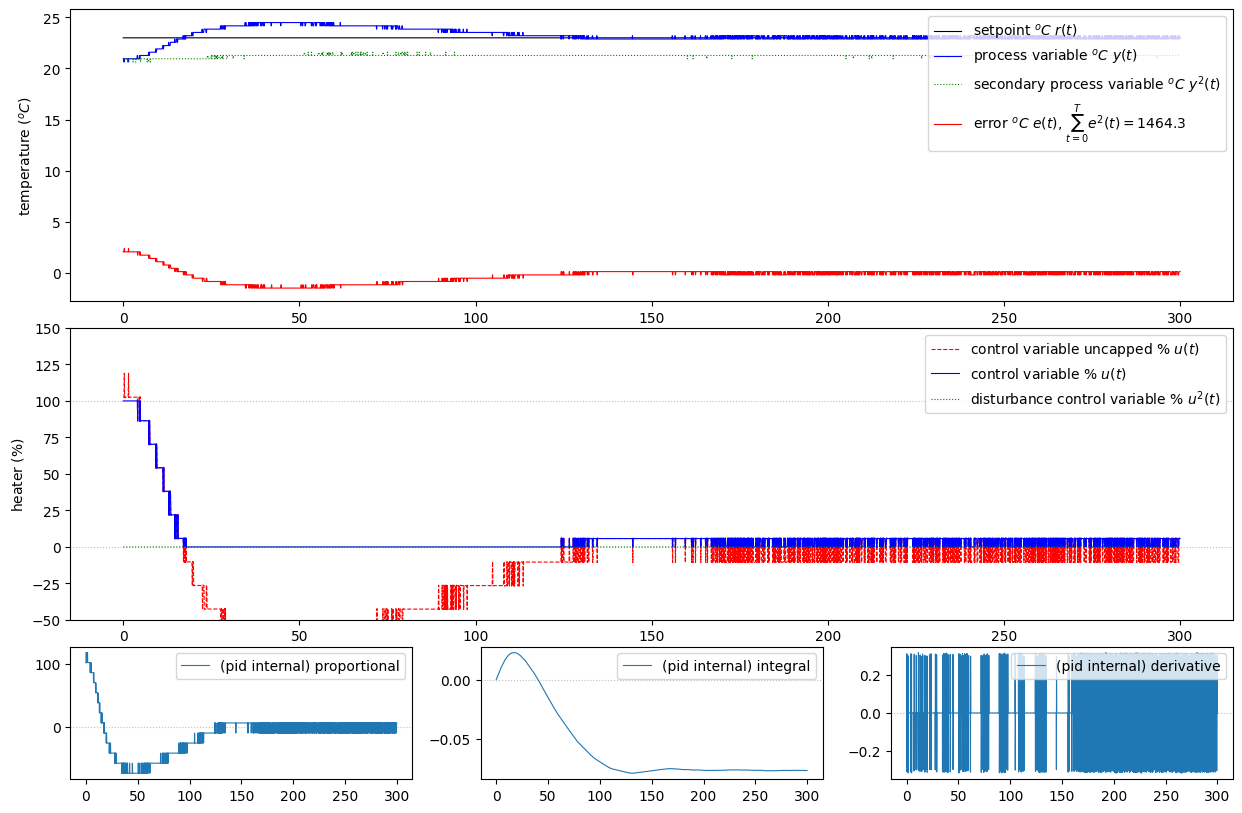

In [7]:
plot_episode(fixed_setpoint_results)


---
## Step Response Tracking
Next, we do the same, but change the setpoint after a few seconds.

In [8]:
setpoints = np.zeros(EPISODE_LENGTH)
setpoints[:] = 23.0 # °C
setpoints[int(EPISODE_LENGTH/2):] = 40.0 # °C

plant_control = PlantControl(IS_HARDWARE, SAMPLE_RATE)
stepped_setpoint_results = plant_control.episode(setpoints, (50.0, 0.001, 0.1))

stepped_setpoint_results.sample(10).sort_values(COL_TIME)


TCLab version 0.4.10dev
Simulated TCLab


,time $sec$,setpoint $^oC\ r(t)$,proportional gain $K_p$,integral gain $K_i$,derivative gain $K_d$,(pid internal) proportional,(pid internal) integral,(pid internal) derivative,error $^oC\ e(t)$,control variable uncapped $\%\ u(t)$,control variable $\%\ u(t)$,process variable $^oC\ y(t)$,disturbance control variable $\%\ u^2(t)$,secondary process variable $^oC\ y^2(t)$,state
155,15.5,23.0,50.0,0.001,0.1,5.835,0.022831,-0.000000,0.1167,5.857831,5.857831,22.8833,0.0,20.9495,0.0
464,46.4,23.0,50.0,0.001,0.1,-74.740,-0.009747,-0.000000,-1.4948,-74.749747,0.000000,24.4948,0.0,21.2718,0.0
615,61.5,23.0,50.0,0.001,0.1,-58.625,-0.032430,-0.000000,-1.1725,-58.657430,0.000000,24.4948,0.0,21.2718,0.0
749,74.9,23.0,50.0,0.001,0.1,-58.625,-0.049141,-0.000000,-1.1725,-58.674141,0.000000,24.1725,0.0,21.2718,0.0
1581,158.1,40.0,50.0,0.001,0.1,823.605,0.065935,-0.000000,16.4721,823.670935,100.000000,23.5279,0.0,21.2718,0.0
1595,159.5,40.0,50.0,0.001,0.1,807.490,0.089765,-0.000000,16.1498,807.579765,100.000000,23.8502,0.0,21.2718,0.0
1857,185.7,40.0,50.0,0.001,0.1,436.845,0.440199,-0.313389,8.7369,436.971810,100.000000,31.2631,0.0,21.9164,0.0
1929,192.9,40.0,50.0,0.001,0.1,324.040,0.498028,-0.000000,6.4808,324.538028,100.000000,33.5192,0.0,22.2387,0.0
2269,226.9,40.0,50.0,0.001,0.1,-62.720,0.558563,-0.000000,-1.2544,-62.161437,0.000000,41.2544,0.0,23.8502,0.0
2337,233.7,40.0,50.0,0.001,0.1,-62.720,0.549662,-0.000000,-1.2544,-62.170338,0.000000,40.9321,0.0,23.8502,0.0


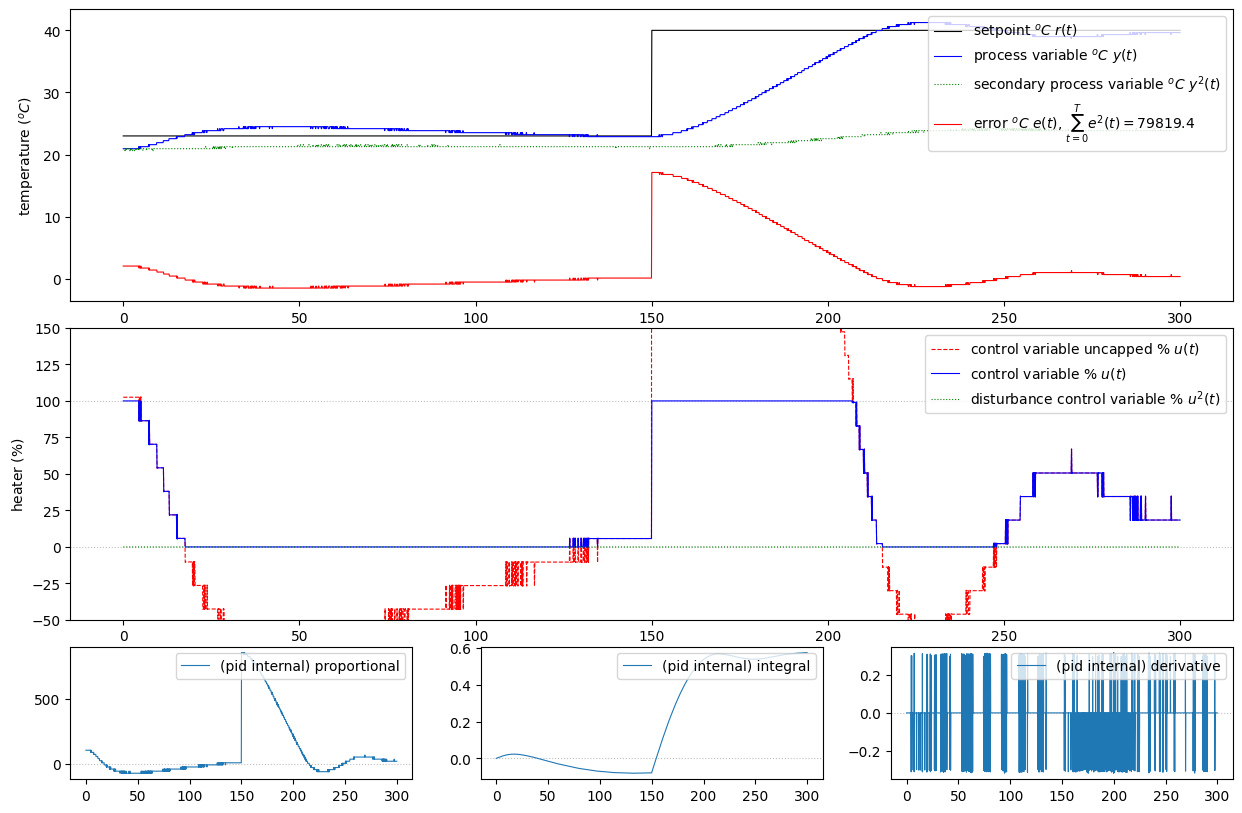

In [9]:
plot_episode(stepped_setpoint_results)


---
## Add Stability Preserving Supervisor
The next step is to add the supervisor to the system. This supervisor acts as proposed in [Stability-preserving automatic tuning of PID control with reinforcement learning](https://comengsys.com/article/view/4601) and replaced the PID parameters with fallback ones if the system appears to be unstable.

From reading the paper, it seems that the proposed algorithm uses the accumulated error as the inverse reward. Also, the proposed supervisor algorithm compares the _running_ squared error $RR(t)$ in an episode with the _total_ squared error $R_{bmk}$. We expected both to be either total or running, but one and the other. In the code below, we follow the same pattern: comparing a running error with a total-for-an-episode benchmark.

In [Stability-preserving automatic tuning of PID control with reinforcement learning](https://comengsys.com/article/view/4601), they base this decision on the cumulative error for an episode, but that is useful only for episodes where the setpoint $r(t)$ does not change. Changing setpoints would punish the algorithm for something it has no control over. The article solves this by assuming the setpoint does not change.

<center><img alt="state diagram" src="state-diagram.png" /></center>


In [10]:
class SupervisedPlantControl:
    def __init__(self, is_hardware, sample_rate, benchmark_error, lamba_error, known_good_pid_tunings):
        TCLab = tclab.setup(connected=is_hardware)
        self.plant = TCLab()

        self.pid = PID()
        self.pid.sample_time = 1.0 / sample_rate
        self.sample_rate = sample_rate

        self.lambda_benchmark_error = lamba_error * benchmark_error
        self.known_good_pid_tunings = known_good_pid_tunings

    def _step(self, t, r_t, y_t_prev, episode_state):
        self.pid.setpoint = r_t
        u_t_uncapped = self.pid(y_t_prev)

        u_t = u_t_uncapped
        if u_t < 0.0:
            u_t = 0.0
        if u_t > 100.0:
            u_t = 100.0

        self.plant.U1 = u_t
        y_t  = self.plant.T1
        y2_t = self.plant.T2

        return [t, r_t,
                self.pid.tunings[0], self.pid.tunings[1], self.pid.tunings[2],
                self.pid._proportional, self.pid._integral, self.pid._derivative,
                self.pid._last_error, u_t_uncapped, u_t, y_t,
                0.0, y2_t,
                episode_state], y_t

    def episode(self, setpoints, pid_tunings):
        results = pd.DataFrame(columns=EPISODE_COLUMNS)

        episode_state = STATE_NORMAL
        self.pid.tunings = pid_tunings
        y_t_prev = self.plant.T1
        for t in range(len(setpoints)):
            time.sleep(1.0 / self.sample_rate)
    
            step_data, y_t_prev = self._step(t / self.sample_rate, setpoints[t], y_t_prev, episode_state)
            results.loc[len(results)] = step_data

            # in fallback state we just sit the episode out
            if episode_state != STATE_FALLBACK and \
                    (results[COL_ERROR]**2).sum() > self.lambda_benchmark_error:
                print(f"at {t}: running error {(results[COL_ERROR]**2).sum():.1f} above lamda*benchmark error {self.lambda_benchmark_error:.1f}, switched to fallback parameters")
                episode_state = STATE_FALLBACK
                results.loc[len(results)-1][COL_STATE] = STATE_FALLBACK
                self.pid.tunings = self.known_good_pid_tunings
                self.pid.reset()

        return results


In [11]:
setpoints = np.zeros(EPISODE_LENGTH)
setpoints[:] = 23.0 # °C

plant_control = SupervisedPlantControl(IS_HARDWARE, SAMPLE_RATE, 1200.0, 1.0, (20.0, 0.1, 0.01))
supervised_smooth_results = plant_control.episode(setpoints, (50.0, 0.001, 0.1))

supervised_smooth_results.sample(10).sort_values(COL_TIME)


TCLab version 0.4.10dev
Simulated TCLab
at 700: running error 1201.3 above lamda*benchmark error 1200.0, switched to fallback parameters


,time $sec$,setpoint $^oC\ r(t)$,proportional gain $K_p$,integral gain $K_i$,derivative gain $K_d$,(pid internal) proportional,(pid internal) integral,(pid internal) derivative,error $^oC\ e(t)$,control variable uncapped $\%\ u(t)$,control variable $\%\ u(t)$,process variable $^oC\ y(t)$,disturbance control variable $\%\ u^2(t)$,secondary process variable $^oC\ y^2(t)$,state
115,11.5,23.0,50.0,0.001,0.10,38.065,0.020746,-0.304430,0.7613,37.781316,37.781316,22.2387,0.0,20.9495,0.0
209,20.9,23.0,50.0,0.001,0.10,-26.395,0.022023,-0.000000,-0.5279,-26.372977,0.000000,23.5279,0.0,20.9495,0.0
378,37.8,23.0,50.0,0.001,0.10,-74.740,0.003508,-0.308475,-1.4948,-75.044967,0.000000,24.4948,0.0,21.2718,0.0
457,45.7,23.0,50.0,0.001,0.10,-74.740,-0.008852,-0.000000,-1.4948,-74.748852,0.000000,24.4948,0.0,21.2718,0.0
458,45.8,23.0,50.0,0.001,0.10,-74.740,-0.009012,-0.000000,-1.4948,-74.749012,0.000000,24.1725,0.0,21.2718,0.0
1272,127.2,23.0,20.0,0.100,0.01,-4.112,-3.698065,-0.000000,-0.2056,-7.810065,0.000000,22.8833,0.0,21.2718,1.0
1459,145.9,23.0,20.0,0.100,0.01,2.334,-3.567007,-0.000000,0.1167,-1.233007,0.000000,22.8833,0.0,21.2718,1.0
1723,172.3,23.0,20.0,0.100,0.01,8.780,-2.561005,0.031265,0.4390,6.250261,6.250261,22.5610,0.0,21.2718,1.0
2314,231.4,23.0,20.0,0.100,0.01,2.334,-1.016934,-0.000000,0.1167,1.317066,1.317066,22.8833,0.0,21.2718,1.0
2885,288.5,23.0,20.0,0.100,0.01,2.334,0.100816,-0.000000,0.1167,2.434816,2.434816,22.8833,0.0,21.2718,1.0


accumulated error

In [12]:
(supervised_smooth_results[COL_ERROR]**2).sum()


1610.5208407999983

final state

In [13]:
supervised_smooth_results.loc[len(supervised_smooth_results)-1][COL_STATE]


1.0

moment of switch to fallback

In [14]:
np.searchsorted(supervised_smooth_results[COL_STATE], STATE_FALLBACK)


700

In [15]:
np.searchsorted(stepped_setpoint_results[COL_STATE], STATE_FALLBACK)


3000

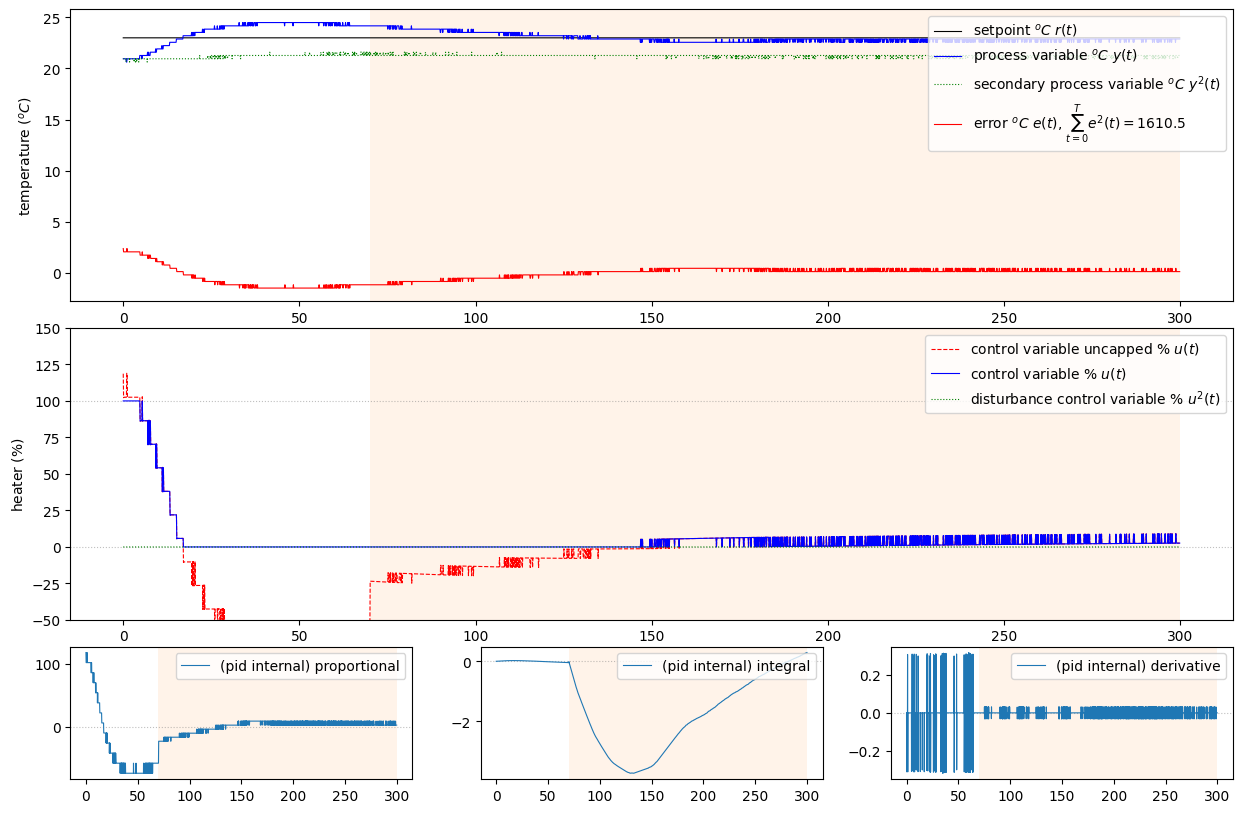

In [16]:
plot_episode(supervised_smooth_results)


---
## Generating Episodes
Let's look at how we can generate, store and retrieve episodes. We'd like to build up a collection of episodes that we can use as trainging data, as well as have code that we can use to bulk generate episodes, using the simulated TCLab.

Since we already have a nice way of visualing graphs, it's probably good to generate a set of graphs for each episode we store.

The code below is just to make things work. We'll make a deamon out of it to generate actual episodes on a server somewhere.

In [17]:
def generate_save_and_plot_episode(plant, setpoint, pid_tunings, n_episodes, directory):
    os.makedirs(directory, exist_ok=True)

    setpoints = np.zeros(EPISODE_LENGTH)
    setpoints[:] = setpoint

    for i in range(n_episodes):        
        basename = datetime.utcnow().isoformat()
        episode_file = f"{directory}/{basename}Z.parquet"
        episode_plot = f"{directory}/{basename}Z.png"

        print(f"generating episode {basename}...")

        results = plant_control.episode(setpoints, pid_tunings)
        results.to_parquet(episode_file)
        plot_episode(results, episode_plot)
    

In [20]:
plant_control = SupervisedPlantControl(IS_HARDWARE, SAMPLE_RATE, 1200.0, 1.0, (20.0, 0.1, 0.01))
generate_save_and_plot_episode(plant_control, 23.0, (50.0, 0.001, 0.1), 2, "episodes")


TCLab version 0.4.10dev
Simulated TCLab
generating episode 2023-07-28T07:31:12.333773...
at 698: running error 1200.4 above lamda*benchmark error 1200.0, switched to fallback parameters
generating episode 2023-07-28T07:36:27.596207...


---
## Reading List
This section lists what sites and articles formed the basis of this notebook.

### Literature
The literature containts meaty explanations of the concepts used. Some were used to inspire, others we copied code from.

* https://comengsys.com/article/view/4601 and https://www.youtube.com/watch?v=ymodIJ7yMKo inspired the whole project.
* https://www.apmonitor.com/pdc/index.php/Main/FirstOrderSystems, https://www.apmonitor.com/pdc/index.php/Main/FirstOrderGraphical, and https://github.com/APMonitor/pdc/blob/master/fopdt_widget.ipynb helped build the plant simulation.

### Reference Material
Reference material is a list of sources for small snippets of code or that were used to solve problems we ran into as part of making this notebook.

* https://pypi.org/project/simple-pid/
* https://tclab.readthedocs.io/en/latest/README.html
* https://numpy.org/doc/stable/reference/
* https://stackoverflow.com/questions/14058340/adding-noise-to-a-signal-in-python
* https://tex.stackexchange.com/questions/384873/what-is-the-degree-symbol
* https://tex.stackexchange.com/questions/74353/what-commands-are-there-for-horizontal-spacing